In [22]:
from Helpers import *
from FLController import *

In [42]:
def Feedback_Linearization_Random(Duration = .6,w1 = 1e8,w2 = 1e8,w3 = 1e4,w4 = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,alpha = 1,Activate_Noise = False,Side = "Left",newtonfunc = newtonf,newtondfunc = newtondf,Num_iter = 300, ShowJ = False, ShowEstimate = False,Delay = .06,FF = False):


    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))

    #Incorporation of delay 

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    S = Q

    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = S
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B_basic.T@S@B_basic)@B_basic.T@S@A_basic
        array_L[Num_iter-2-k] = L
        S = A_basic.T@S@(A_basic-B_basic@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_x = np.zeros((Num_iter,Num_Var-2)) 
    array_z = np.zeros((Num_iter,Num_Var)) 
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x = np.zeros(Num_Var-2)
    x[0],x[1] = x0[0],x0[3]
    new_x = np.copy(x)

    #Incorporation of delay 

    #Perform the task
    J = 0
    acc = np.zeros(2)
    for k in range(Num_iter-1):
        #Compute the matrices of the FL technique in function of the current estimate state 
        if (np.sin(x[0]+x[1])*33+np.sin(x[0])*30 > 35) and (FF == True):

            F = Compute_f_new_version(x[0:2],x[2:4],acc,1)
            if Side == "Left": F*=-1

        else : 
            F = [0,0]

        Omega_sens,motor_noise,Omega_measure,measure_noise = Compute_Noise(Num_Var,alpha,B,kdelay)

        C = np.zeros(2).T
        M = np.array([[a1+2*a2*cos(zhat[3]),a3+a2*cos(zhat[3])],[a3+a2*cos(zhat[3]),a3]])

        Cdot = np.zeros(2).T
        Mdot = np.array([[-2*a2*sin(zhat[3])*zhat[4],-a2*sin(zhat[3])*zhat[4]],[-a2*sin(zhat[3])*zhat[4],0]])
       
        # Compute the command through the FL technique
        
        v = -L[k].reshape(np.flip(B_basic.shape))@zhat[:Num_Var]
        u = 1/Kfactor*M@(v)+1/Kfactor*Mdot@(np.array([zhat[2],zhat[5]]))+M@(np.array([zhat[2],zhat[5]]))+C+Bdyn@np.array([zhat[1],zhat[4]])+1/Kfactor*Cdot+1/Kfactor*Bdyn@np.array([zhat[2],zhat[5]])
        if ShowJ : J+= u.T@R@u
        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        if Activate_Noise : y[k]+=measure_noise
        
        # Kalman Filter Gains 

        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T

        # Compute the Estimation of the system in the linear system
        
        zhat = A@zhat + B@v + K@(y[k]-H@zhat)
        
        # Simulate the nonlinear plant 
        
        C = np.zeros(2).T
        
        M = np.array([[a1+2*a2*cos(x[1]),a3+a2*cos(x[1])],[a3+a2*cos(x[1]),a3]])

        
        Cdot = np.zeros(2).T

        Mdot = np.array([[-2*a2*sin(x[1])*x[3],-a2*sin(x[1])*x[3]],[-a2*sin(x[1])*x[3],0]])
        
        #print(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))-acc)
        new_x[0:2] += dt*x[2:4]
        new_x[2:4] += dt*(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))+F)
        new_x[4:6] += dt*Kfactor*(u-x[4:6])

        z = np.concatenate((np.array([new_x[0],new_x[2],acc[0],new_x[1],new_x[3],acc[1],z[6],z[7]]),z[:-Num_Var]))
        if Activate_Noise : z+=motor_noise
        
        # Transform the new nonlinear state into the coordinates of the linear system
        C = np.zeros(2).T

        M = np.array([[a1+2*a2*cos(z[3]),a3+a2*cos(z[3])],[a3+a2*cos(z[3]),a3]])

        acc = np.linalg.solve(M,(new_x[4:6]-Bdyn@(new_x[2:4])-C))+F
        #Stock the true and estimated states

        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()
        array_x[k+1] = new_x[:Num_Var-2].flatten()
        
        x = np.copy(new_x)
        

    if ShowJ : 
        #J+= z.T@Q@z
        print("Total cost of FL: "+str(J)[:7])

    #Change of coordinates from angular to cartesian 
    

    X = np.cos(array_z[:,0]+array_z[:,3])*33+np.cos(array_z[:,0])*30
    Y = np.sin(array_z[:,0]+array_z[:,3])*33+np.sin(array_z[:,0])*30

    if ShowEstimate:
        X2 = np.cos(array_zhat[:,0]+array_zhat[:,3])*33+np.cos(array_zhat[:,0])*30
        Y2 = np.sin(array_zhat[:,0]+array_zhat[:,3])*33+np.sin(array_zhat[:,0])*30

    #Plotting
    color1 = plt.get_cmap('RdPu')(kdelay*10 / Num_iter)

    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        if Delay > 0 : plt.plot(X,Y,color = "cyan",label = "FL movement with "+str(int(kdelay*dt*1000))+ " \n ms delay",linewidth = 1)
        else : plt.plot(X,Y,color = "#48494B",label = "Feedback Linearization",linewidth = 1)
        if ShowEstimate: 
            plt.plot(X2,Y2,color ="black",label = "Estimation",linewidth = 1,linestyle = "--",alpha = .8)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "orange",marker = "s" , s = 600, alpha= .3)
    if ShowJ : return X,Y,J,x
    return X,Y

In [24]:
def LQGeasy(Duration = .6,w1 = 1e8,w2 = 1e8,w3 = 1e4,w4 = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,Var = 1e-6,alpha = 1,Activate_Noise = False,Side = "Left",newtonfunc = newtonf,newtondfunc = newtondf,Num_iter = 300, ShowJ = False, ShowEstimate = False,Delay = .06,FF = False):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noises in the model

    Side (String) : Side of the force field ("Left" or "Right")
    
    newtonfunc([thetas,thetae],X,Y) : Function that computes the difference between the change of variable from the angular to cartesian system, and the targetted X,Y position
                                      It's a tool for the newton method to compute the desired joint angles that generate a precise X,Y position of the hand

    newtondfunc([thetas,thetae],X,Y) : Derivative of newtonfunc

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement
    """

    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 


    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])

    #Incorporation of delay 

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    Sx = np.zeros(A.shape)
    Sx[:Num_Var,:Num_Var] = Q
    Se = np.zeros(A.shape)

    
    Omega_sens,motor_noise,Omega_measure,measure_noise,Cnoise,mult_noise = Compute_Multiplicative_Noise(Num_Var,alpha,B,Var)
    Ccal = np.zeros(R.shape)
    L = np.zeros((Num_iter-1,2,Num_Var*(kdelay+1)))
    K = np.zeros((Num_iter-1,A.shape[0],Num_Var))
    sigma = np.zeros((Num_iter,A.shape[0],A.shape[0]))
    for k in range(Num_iter-1):
        K[k] = A@sigma[k]@H.T@np.linalg.inv(H@sigma[k]@H.T+Omega_measure)
        sigma[k+1] = Omega_sens + (A - K[k]@H)@sigma[k]@A.T
    for k in range(Num_iter-1):
        for i in range(B.shape[1]):
            Ccal+=Cnoise[i].T@(Sx+Se)@Cnoise[i]
        L[Num_iter-2-k] = np.linalg.inv(R+B.T@Sx@B+Ccal)@B.T@Sx@A
        Sx = A.T@Sx@(A-B@L[Num_iter-2-k])
        Se = A.T@Sx@B@L[Num_iter-2-k]+(A-K[Num_iter-2-k]@H).T@Se@(A-K[Num_iter-2-k]@H)

    
    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_z = np.zeros((Num_iter,Num_Var)) 
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Incorporation of delay 

    #Perform the task
    J = 0

    for k in range(Num_iter-1):
        #Compute the matrices of the FL technique in function of the current estimate state 


    
        # Compute the command through the FL technique
        Omega_sens,motor_noise,Omega_measure,measure_noise,Cnoise,mult_noise = Compute_Multiplicative_Noise(Num_Var,alpha,B,Var)
        
        v = -L[k].reshape(np.flip(B.shape))@zhat
        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        if Activate_Noise : y[k]+=measure_noise
        
        # Kalman Filter Gains 

        

        # Compute the Estimation of the system in the linear system
        zhat = A@zhat + B@v + K[k]@(y[k]-H@zhat)
        z = A@z+B@v

        if Activate_Noise : z+=motor_noise+mult_noise@v


        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()


    if ShowJ : 
        #J+= z.T@Q@z
        print("Total cost of FL: "+str(J)[:7])

    #Change of coordinates from angular to cartesian 
    

    X = np.cos(array_z[:,0]+array_z[:,3])*33+np.cos(array_z[:,0])*30
    Y = np.sin(array_z[:,0]+array_z[:,3])*33+np.sin(array_z[:,0])*30

    if ShowEstimate:
        X2 = np.cos(array_zhat[:,0]+array_zhat[:,3])*33+np.cos(array_zhat[:,0])*30
        Y2 = np.sin(array_zhat[:,0]+array_zhat[:,3])*33+np.sin(array_zhat[:,0])*30

    #Plotting
    color1 = plt.get_cmap('RdPu')(kdelay*10 / Num_iter)

    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        plt.plot(X,Y,color = "magenta",label = "LQG for $\dddot{\\theta}=$ v",linewidth = 5)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "orange",marker = "s" , s = 600, alpha= .3)
    return array_z,dt



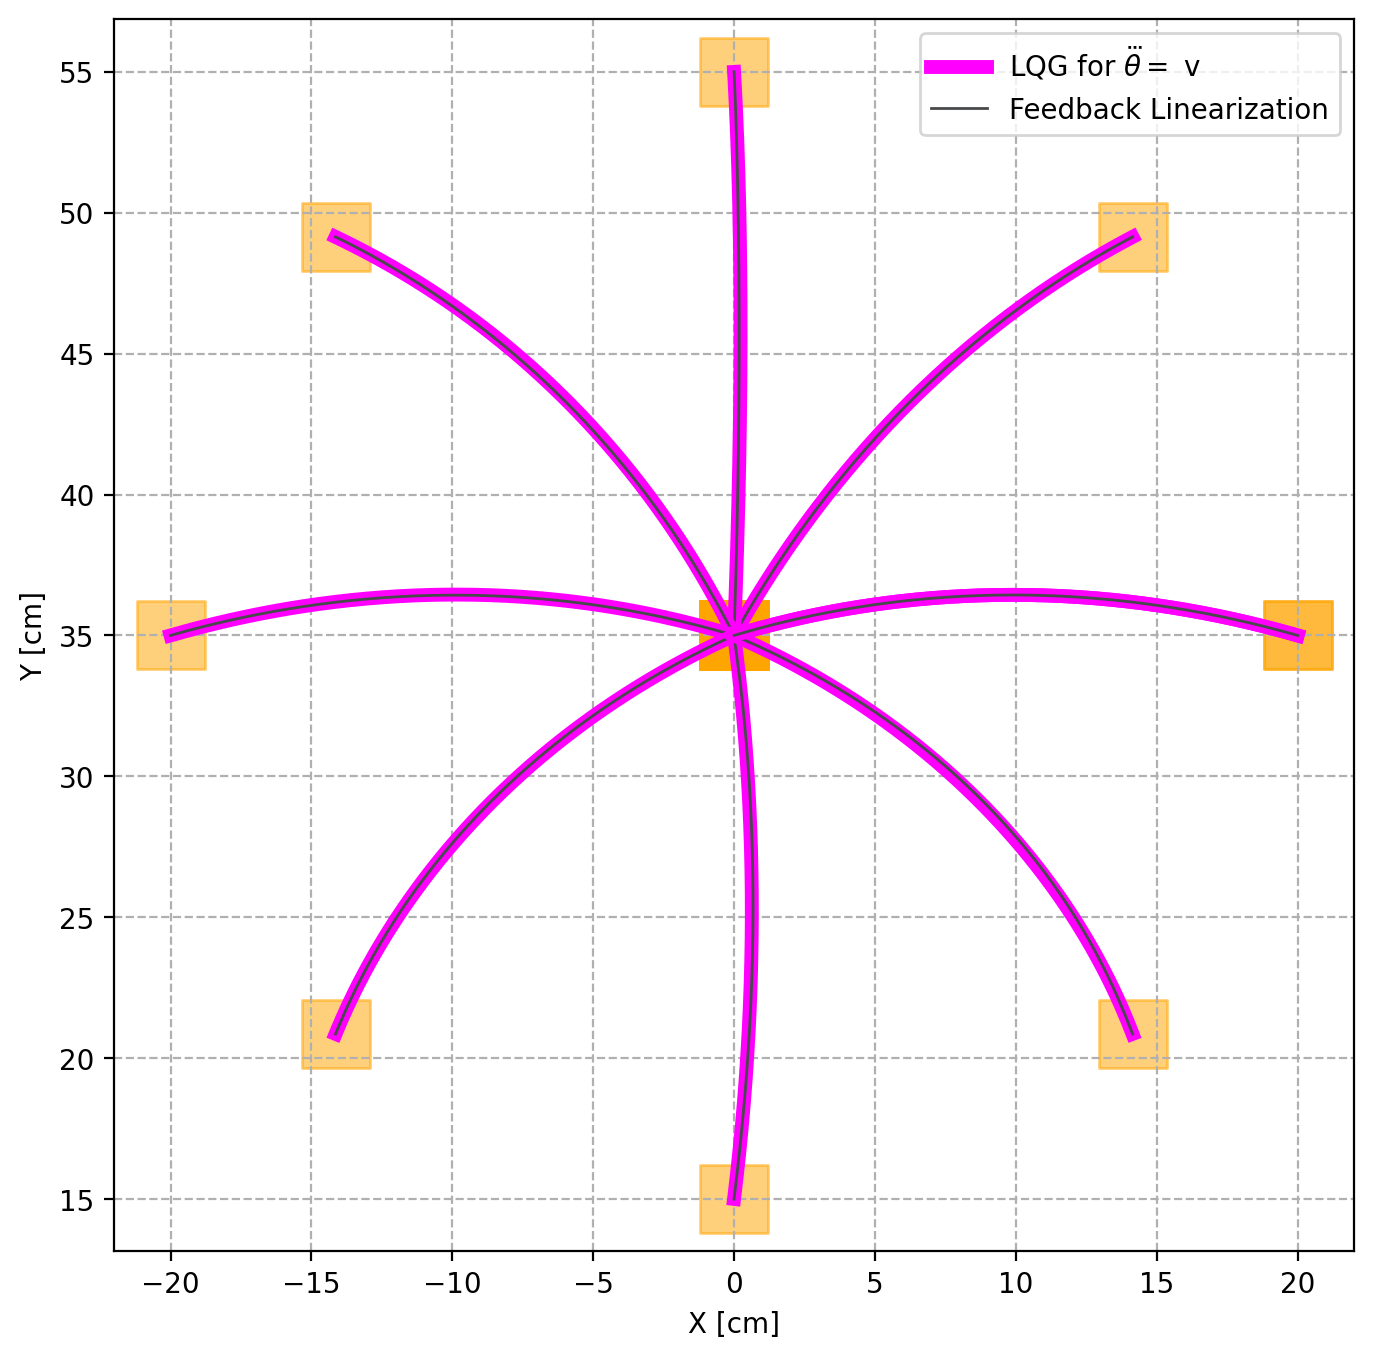

In [43]:
plt.figure(figsize=(8,8),dpi= 200)
start = np.array([0,35])
Movement_Length = 20
Num_targets = 9
theta=np.linspace(0,2*pi,Num_targets)
reach = Movement_Length*np.array([np.cos(theta),np.sin(theta)])
for k in range(Num_targets):
    target = start+reach[:,k]
    z,dt = LQGeasy(starting_point=start,targets=target,Activate_Noise=False,Delay=0)
    x,dt=Feedback_Linearization_MultNoise(Activate_Noise = False,starting_point=start,targets=target,Delay=0) 

MultipleLabel()

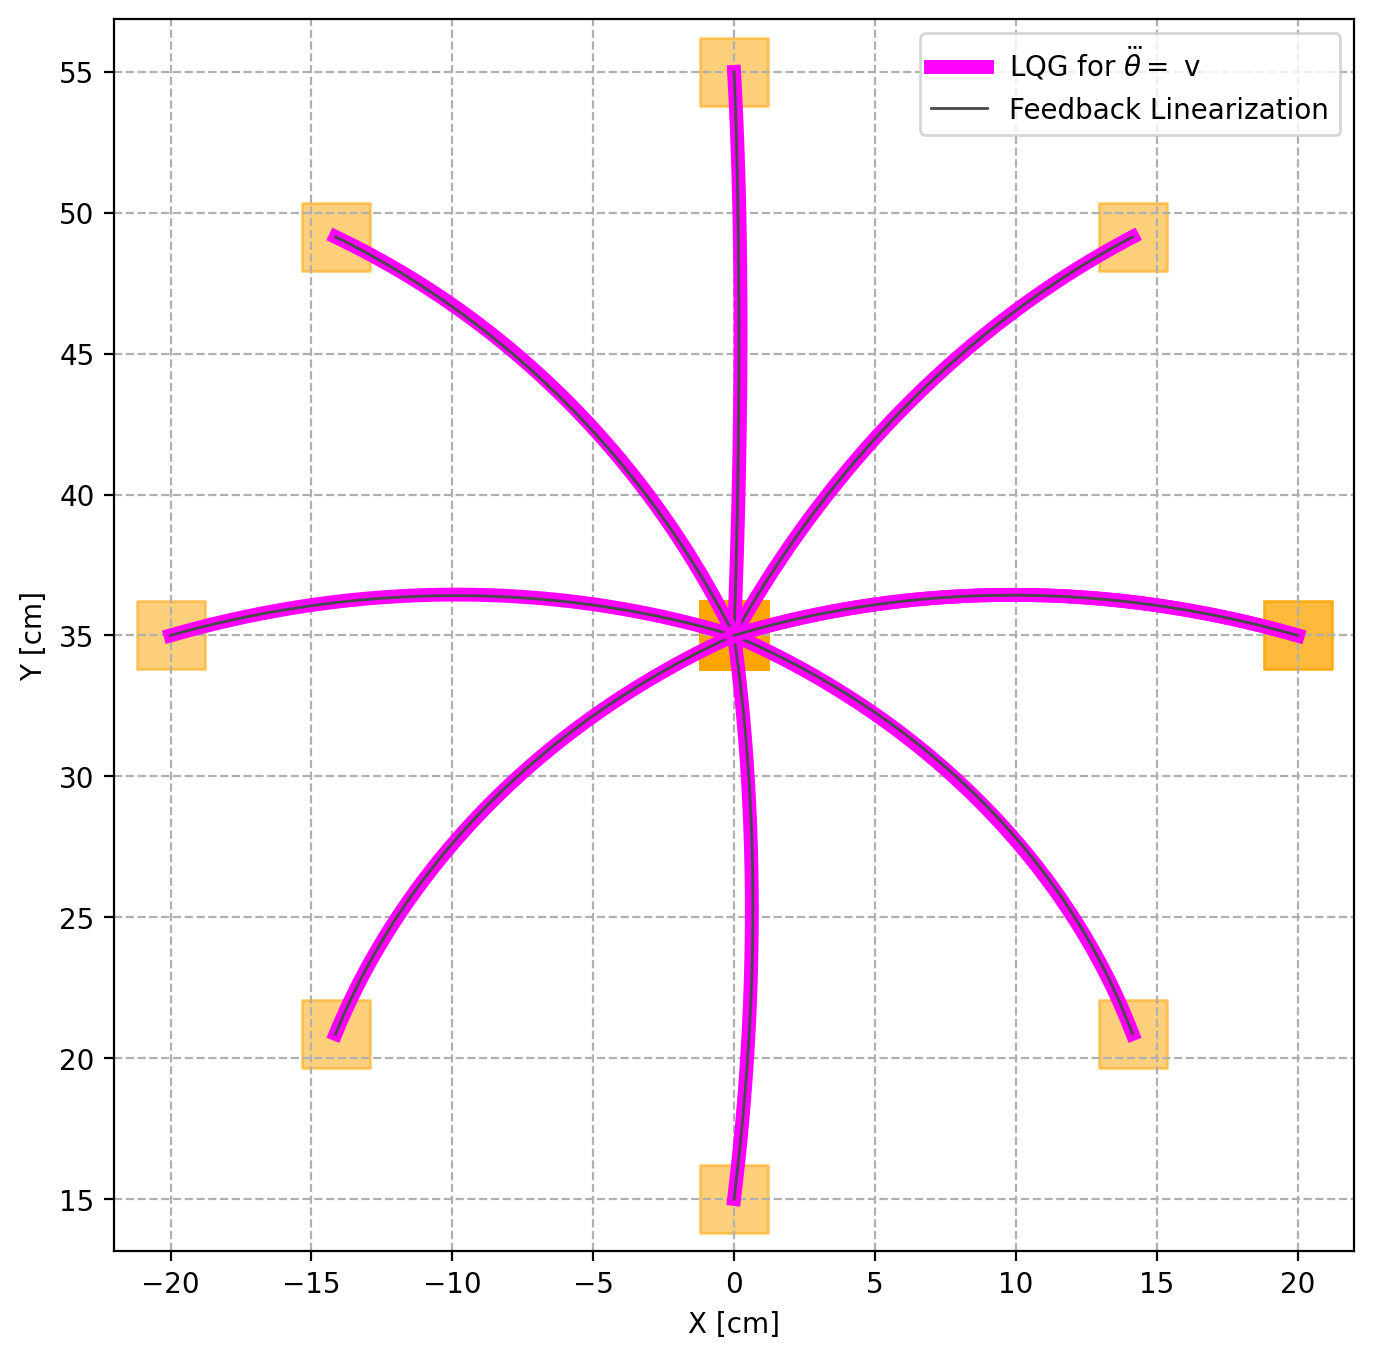

In [44]:
plt.figure(figsize=(8,8),dpi= 200)
start = np.array([0,35])
Movement_Length = 20
Num_targets = 9
theta=np.linspace(0,2*pi,Num_targets)
reach = Movement_Length*np.array([np.cos(theta),np.sin(theta)])
for k in range(Num_targets):
    target = start+reach[:,k]
    z,dt = LQGeasy(starting_point=start,targets=target,Activate_Noise=False,Delay=0)
    x,dt=Feedback_Linearization_Random(Activate_Noise = False,starting_point=start,targets=target,Delay=0) 

MultipleLabel()